In [ ]:
import requests
! pip install nested-lookup
from nested_lookup import nested_lookup 

! pip install pandas
import pandas as pd
! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import csv

La fonction *find_references* ci-dessous permet d'interroger l'interface de programmation HAL (https://api.archives-ouvertes.fr/docs) pour récupérer l'ensemble des notices présentes sur l'archive ouverte correspondantes à un champ parametré (*field*, *field_value*).

In [3]:
def find_notices(field_value, field, increment=0):
    notices = []
    
    # Paramétrage des champs à récupérer, ici nous récupérons ceux qui importent pour le calcul de la métrique MDS
    # https://api.archives-ouvertes.fr/docs/search/?schema=fields#fields
    flags = "docid,halId_s,doiId_s," \
        "fileMain_s,title_s,*_abstract_s,*_keyword_s,fulltext_t,domain_s,primaryDomain_s,docType_s," \
        "conferenceEndDate_tdate,conferenceStartDate_tdate,defenseDate_tdate,ePublicationDate_tdate," \
        "producedDate_tdate,publicationDate_tdate,releasedDate_tdate,writingDate_tdate," \
        "submittedDateY_i,modifiedDateY_i"
    
    # Interrogation de l'API HAL
    req = requests.get(
        "http://api.archives-ouvertes.fr/search/?q=" + field + ":" + str(field_value) + "&fl=" + flags + "&start=" + str(
            increment))

    if req.status_code == 200:
        data = req.json()
        if "response" in data.keys():
            data = data["response"]
            count = data["numFound"]

            for notice in data["docs"]:
                notices.append(notice)
            if (count > 30) and (increment < count):
                increment += 30
                # Boucle pour obtenir l'intégralité des documents liés à la requête d'origine
                # La réponse de l'API se limitant à 30 notices pour chaque appel
                tmp_notices = find_notices(field_value, field, increment=increment)
                for tmp_notice in tmp_notices:
                    notices.append(tmp_notice)
                return notices
            else:
                return notices
        else:
            print("Warning : wrong response from HAL API endpoint (" + field_value + ")")
            return notices
    else:
        print("Warning : can not reach HAL API endpoint")
        return notices

La fonction *calculate_mds* ci-dessous permet de calculer la métrique MDS pour une notice donnée (dictionnaire).

In [4]:
def calculate_mds(doc):
    score = 0

    abstract_penalty = False

    # Vérification de la présence d'un titre
    if "title_s" in doc:
        has_title = True
    else:
        has_title = False

    # Vérification de la présence d'un DOI
    if "doiId_s" in doc:
        has_doi = True
        if doc["doiId_s"] == "":
            has_doi = False
    else:
        has_doi = False

    # Vérification d'une date de publication (ou d'une date de conférence, etc.)
    if "publicationDate_tdate" in doc or "conferenceStartDate_tdate" in doc or "conferenceEndDate_tdate" in doc \
            or "defenseDate_tdate" in doc or "ePublicationDate_tdate" in doc or "producedDate_tdate" in doc \
            or "releasedDate_tdate" in doc or "writingDate_tdate":
        has_publication_date = True
    else:
        has_publication_date = False

    # Vérification de la présence de mots-clés quelque soit la langue (préfixe _keyword_s)
    keywords = nested_lookup(
        key="_keyword_s",
        document=doc,
        wild=True,
        with_keys=True,
    )

    if len(keywords) > 0:
        has_kw = True
    else:
        has_kw = False

    # Vérification de la présence de résumé quelque soit la langue (préfixe _abstract_s)
    abstracts = nested_lookup(
        key="_abstract_s",
        document=doc,
        wild=True,
        with_keys=True,
    )

    # Vérification de la présence d'un résumé
    sub_abstract_penalty = 0
    for abstract in abstracts:
        # Filtrage si le résumé est égal à "no abstract"
        if len(doc[abstract][0].split()) < 3:
            sub_abstract_penalty += 1

    if sub_abstract_penalty == len(abstracts) and (sub_abstract_penalty != 0):
        abstract_penalty = True

    if len(abstracts) > 0 and not abstract_penalty:
        has_abstract = True
    else:
        has_abstract = False

    # Vérification de la présence d'un fichier (texte complet)
    if 'fileMain_s' in doc:
        has_attached_file = True
    else:
        has_attached_file = False

    # Vérification de la présence d'un domaine
    if 'domain_s' in doc:
        has_domain = True
    else:
        has_domain = False

    if has_title:
        score += 1 * 0.1
    if has_publication_date:
        score += 1 * 0.1
    if has_kw:
        score += 1 * 1
    if has_abstract:
        score += 1 * 0.8
    if has_attached_file:
        score += 1 * 0.4
    if has_doi:
        score += 1 * 0.6
    if has_domain:
        score += 1 * 0.1

    return score / (0.1 + 0.1 + 1 + 0.8 + 0.4 + 0.6 + 0.1)

Le bloc de code suivant permet de lire le fichier *halId_s.csv* qui contient les identifiants HAL des chercheurs de l'Université de Toulon (paramétrés à la date de Septembre 2021). Le traitement consiste ensuite à récupérer les documents liés à chaque identifiant HAL.

In [5]:
# [Optionnel] Nettoyage du fichier CSV où les notices sont écrites
df = pd.read_csv('notices_mds.csv',header=None)
df.head(1).to_csv('notices_mds.csv',index=False, header=False)

In [6]:
halId_s = pd.read_csv("halId_s.csv")

# Boucle dans les identifiants HAL des chercheurs
for index, row in halId_s.iterrows():
    researcher_notices = find_notices(row["halId_s"], "authIdHal_s")

    # Sauvegarde des éléments pertinents pour notre analyse
    for notice in researcher_notices:
        # if "modifiedDateY_i" in notice:
            # notice["submittedDateY_i"] = notice["modifiedDateY_i"]
        if 'doiId_s' not in notice:
            notice["doiId_s"] = ""
            
        with open("notices_mds.csv", "a", encoding="utf-8") as f:
            writer = csv.writer(f, lineterminator="\n")
            writer.writerow([notice["primaryDomain_s"], notice["doiId_s"], notice["submittedDateY_i"], notice["docType_s"], round(calculate_mds(notice), 5)])

print("Récupération des notices terminée")

Récupération des notices terminée


Le bloc de code suivant effectue des opérations sur le jeu de données pour montrer l'évolution des dépôts et de la métrique MDS selon l'année.

Moyenne de la métrique MDS des dépôts du jeu de données : 0.426
Nombre de dépôts dans le jeu de données : 6004


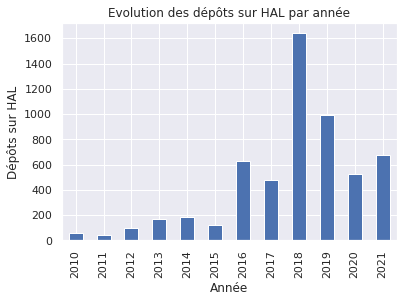

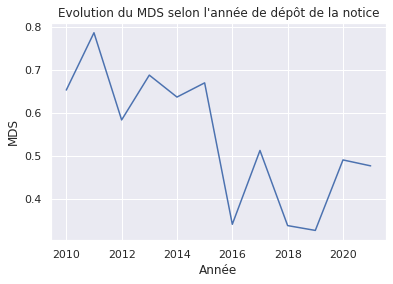

In [7]:
notices = pd.read_csv("notices_mds.csv")

print("Moyenne de la métrique MDS des dépôts du jeu de données : " + str(round(notices[['mds']].mean()['mds'], 3)))
print("Nombre de dépôts dans le jeu de données : " + str(len(notices.index)))

# Pour des raisons de lisibilité, suppression des résultats précédents l'année 2010 et ceux de l'année 2022 (en cours)
notices.drop(notices.index[notices['submittedDateY_i'] < 2010], inplace=True)
notices.drop(notices.index[notices['submittedDateY_i'] > 2021], inplace=True)
notices = notices.sort_values(by=['submittedDateY_i'])

# Calcul des dépôts par année
notices_per_year = notices.groupby('submittedDateY_i').size()

# Calcul de la moyenne de la métrique MDS par année
notices_per_year_mean = notices.groupby('submittedDateY_i').mean()

sns.set()

notices_per_year.plot(kind='bar', title="Evolution des dépôts sur HAL par année", legend=None)
plt.xlabel('Année')
plt.ylabel('Dépôts sur HAL')
plt.show()

notices_per_year_mean.plot(title="Evolution du MDS selon l'année de dépôt de la notice", legend=None)
plt.xlabel('Année')
plt.ylabel('MDS')
plt.show()

Le bloc de code suivant effectue des opérations sur le jeu de données pour montrer l'évolution des dépôts et de la métrique MDS selon la catégorie scientifique (STM ou SHS) à laquelle la notice appartient.

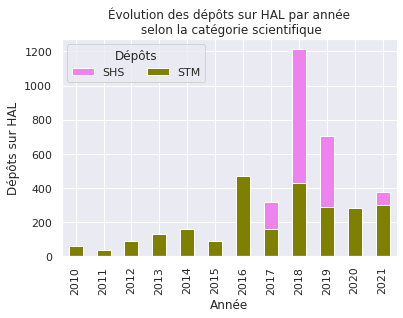

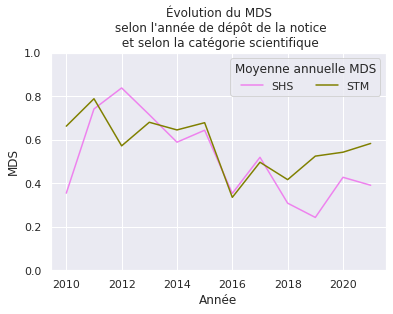

In [8]:
# Informations sur une abbréviation d'un domaine : https://data.archives-ouvertes.fr/subject/shs
shs_domains = ["shs", "qfin", "scco"]

# Tri des notices
notices_shs = notices[notices["primaryDomain_s"].str.contains("|".join(shs_domains)).fillna(False)]
notices_stm = notices[~notices["primaryDomain_s"].str.contains("|".join(shs_domains), na=False).fillna(False)]

# Calcul des dépôts par année pour les SHS puis STM
notices_shs_per_year = notices_shs.groupby("submittedDateY_i").size()
notices_stm_per_year = notices_stm.groupby("submittedDateY_i").size()

# Calcul de la moyenne de la métrique MDS par année pour les SHS puis STM
notices_shs_per_year_mean = notices_shs.groupby("submittedDateY_i").mean()
notices_stm_per_year_mean = notices_stm.groupby("submittedDateY_i").mean()

# Création du graphique montrant l'évolution des dépôts HAL
notices_shs_per_year.plot(kind="bar", title="Évolution des dépôts sur HAL par année\n selon la catégorie scientifique", label="SHS", color="violet")
notices_stm_per_year.plot(kind="bar", title="Évolution des dépôts sur HAL par année\n selon la catégorie scientifique", label="STM", color="olive")

plt.legend(title="Dépôts", ncol=2)
plt.xlabel("Année")
plt.ylabel("Dépôts sur HAL")
plt.show()

# Création du graphique montrant l'évolution de la métrique MDS
ax = notices_shs_per_year_mean.plot(kind="line", title="Évolution du MDS\n selon l'année de dépôt de la notice\n et selon la catégorie scientifique", color="violet")
notices_stm_per_year_mean.plot(ax=ax, kind="line", title="Évolution du MDS\n selon l'année de dépôt de la notice\n et selon la catégorie scientifique", color="olive")

ax.legend(["SHS", "STM"], title="Moyenne annuelle MDS", ncol=2)

ax.set_ylim([0,1])
plt.xlabel("Année")
plt.ylabel("MDS")
plt.show()